**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Curso: Inteligencia Artificial**

**Primer Semestre 2021**

**Profesor: Luis-Alexander Calvo-Valverde**

**Trabajo Corto:** 05

**Datos de la entrega:** Viernes 11 de junio 2021, a más tardar a las 11:59 pm

**Estudiantes:**
- Estudiante_1
- Estudiante_2


# Parte 1: Aprendizaje por refuerzo


Luego de estudiar el siguiente recurso: https://www.youtube.com/watch?v=u3UjPSJQCT4 (del inicio hasta 01:06:00) debe presentar lo siguiente:
1. Un resumen del contenido del video. (**10 puntos**)
1. Busque en internet un programa en python que implemente aprendizaje por refuerzo y agregue comentarios amplios (en español) donde va explicando el código y cómo la teoría estudiada en el punto anterior se aplica. (**20 puntos**). (Debe aportar todo lo necesario para que el profesor pueda correr dicho código).


## Ejemplo en Python: *Self-Driving Cab*

El objetivo de este ejercicio es utilizar técnicas de aprendizaje por refuerzo para que el Taxi pueda mover pasajeros en un parqueo tomando en cuenta las siguientes consideraciones:
1. Que deje al pasajero en la locación correcta
1. Cuide el tiempo del pasajero, tomando el menor tiempo posible para dejarlo.
1. Tenga en cuenta la seguridad del pasajero y considere todas las reglas de tráfico.

Para este problema debemos primero considerar 3 cosas:

### Recompensas

En primer lugar hay que escoger las recompensas, penalidades y sus magnitudes respectivas. Para esto se puede tomar en cuenta los siguientes puntos:

1. El agente debe recibir una alta recompensa para un viaje exitoso, es decir deja al pasajero en el destino correcto, esto ya que es un comportamiento altamente deseable.
1. El agente debe penalizarse si trata de dejar al pasajero en una locacion incorrecta.
1. El agente debe ser penalizado levemente por no llegar al destino a tiempo. Levemente debido a que se prefiere que el agente llegue tarde en lugar de hacer movimientos incorrectos, para llegar antes al destino.
    

### Espacio de estados

Este es el conjunto de todas las posibles situaciones en las que podría existir nuestro taxi. Contiene información útil para que el agente pueda tomar la acción correcta.

Como se menciona en este caso se presenta un área de estacionamiento para entrenar, un espacio que se podría modelar como una matriz de 5x5, con cuatro ubicaciones válidas para dejar y recoger pasajeros (*R*,*G*,*Y*,*B*) o ((0,0),(0,4),(4,0),(4,3)) respectivamente.

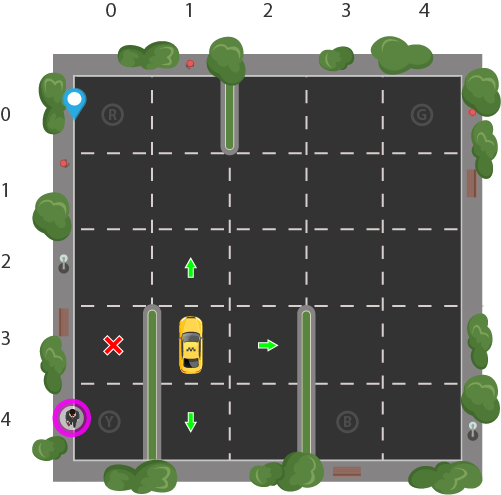

Observe que la ubicación actual del taxi es (3,1). El pasajero se encuentra en la ubicación *Y* y desea ir a la ubicación *R*.
Cuando se contabiliza al pasajero dentro del taxi se contempla un estado extra para cada posible posición. Así tomando todas las combinaciones de locaciones del pasajero, locaciones destino y posiciones en el estacionamiento podemos calcular nuestro total de estados posibles:

$5x5x5x4=500$ 

### Espacio de acciones

Dentro de alguno de los estados el taxi debe tomar una acción, además de moverse en alguna de las cuatro direcciones, este también tiene la capacidad de recoger o dejar a un pasajero, por lo que nuestro conjunto de acciones será:

1. Sur
1. Norte
1. Este
1. Oeste
1. Recoger
1. Dejar

Este es el espacio de acciones: todos las acciones que el agente puede tomar estando en un estado determinado.

Se puede notar en la imagen anterior hay ciertas acciones en ciertos estados que se consideran inválidas, en el código del entorno simplemente se penaliza con -1 cualquier golpe a una pared, por lo que el taxi no se moverá. Esto con el entrenamiento hará que el taxi considere dar la vuelta a la pared.

### Implementación en Python con Gym

En este caso la librería *Gym* de *OpenAI* tiene este caso concreto ya construido para visualizarlo.

*Gym* proporciona diferentes entornos de jeugo que podemos conectar a código nuestro para probar un agente. La librería se encarga de proveer toda la información que el agente puede requerir como acciones, puntaje y estado actual. Así solamente nos centramos en el algoritmo para el agente. 

En este caso el entorno utilizado será *Taxi-v2* el cual ya proporciona toda la información mencionada anteriormente.

In [2]:
!pip3 install scikit-build

     |████████████████████████████████| 81kB 5.4MB/s eta 0:00:011


In [3]:
!pip3 install cmake 'gym[atari]' scipy

In [8]:
import gym

# env corresponde a la interfaz unificada para el entorno
# en este podemos encontrar métodos útiles, entre estos:

# env.reset() (reinicia el ambiente y retorna un estado inicial aleatorio)
# env.step(action) (avanza un paso el ambiente por un paso de tiempo, retorna:
#    observation: observaciones del ambiente
#    reward: si la acción fue beneficiosa o no
#    done: indica si se ha recogido y dejado un pasajero exitosamente, también se llama episode
#    info: información adicional como rendimiento y latencia para debugging)
# env.render() (renderiza un frame del ambiente, útil para la visualización)
env = gym.make("Taxi-v3").env 

# aquí se utiliza .env al final del make para evitar deter el entrenamiento en
# la iteración 200 que es el default para cada versión nueva de Gym

In [14]:
env.reset()  # reinicia el ambiente a un estado aleatorio
env.render()  # lo renderiza para visualizar

print("Tamaño del espacio de acciones: ", format(env.action_space.n))
print("Tamaño del espacio de estados: ", format(env.observation_space.n))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Tamaño del espacio de acciones:  6
Tamaño del espacio de estados:  500


Como se puede observar en el render, este consta de 3 partes, el cuadrado amarillo que representa al taxi sin pasajero (verde con pasajero), las barras ( **|** ) que representan las paredes que el taxi no puede cruzar y las cuatro posiciones (*R*, *G*, *Y* y *B*), la de color azul representa la ubicación de recogida y la roja la ubicación de destino. Así como verificado por *prints* podemos observar un espacio de acciones de tamaño 6 y un espacio de estados de tamaño 500.

Lo único necesario ya es tener una codificación por medio de un número único para cada uno de los estados posibles, y la codificación del 0 al 5 para las acciones. 

El algoritmo de *RL* aprenderá un mapeo de los estados para la acción optima a realizar por medio de exploración. Es decir el agente explora el entorno y toma acciones basadas en las recompensas que puede obtener del entorno.

La acción optima para cada estado es la que tiene mayor recompensa acumulativa a largo plazo.

In [10]:
state = env.encode(3, 1, 2, 0)  # parámetros son:
                                #     3: fila del taxi
                                #     1: columna del taxi
                                #     2: indice del punto donde se encuentra el pasajero
                                #     0: indice del punto de destino

print("Estado: ", state)  # se imprime el numero de estado

env.s = state  # se asigna el nuevo estado
env.render()  # se visualiza el estado

Estado:  328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



En este caso se puede ver cómo utilizamos *env.encode* para codificar con nuestros parámetros y obtener el número de estado correspondiente a este entre 0 y 499.

Luego, podemos establecer el estado del entorno manuanualmente asignando *state* a *env.s*. 

#### La tabla de recompensas

Cuando se crea el entorno de Taxi, también se crea una tabla de recompensas inicial, llamada *P* que tiene el número de estados como filas y el número de acciones como columnas.

Dado que cada estado está en esta tabla, podemos ver los valores de recompensa predeterminados asignados al estado número 328.

In [11]:
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

Este diccionario tiene la estructura: ```{action: [(proba, nextState, reward, done)]}```.

De 0 a 5 corresponden a las acciones a realizar: 
* 0: Sur 
* 1: Norte 
* 2: Este
* 3: Oeste
* 4: Recoger
* 5: Dejar

En este entorno, ```probability``` siempre es 1.0.

```nextState``` es el estado en el que se estará si se toma la acción en este índice del diccionario.

Ahí todas las acciones de movimiento cuentan con una ```reward``` de -1, mientras las acciones de recoger/dejar tienen una ```reward``` de -10. Si se estuviera en un estado en que el taxi tiene un pasajero y se encuentra en la posición de destino correcto, se observaría una ```reward``` de 20 en la acción de dejar (5).

```done``` se utiliza para indicarnos cuándo hemos dejado a un pasajero en el lugar correcto. Cada vez que se deja un pasajero con éxito se le llama el final de un **episodio**.



####Q-Learning

Aquí utilizaremos un algoritmo de Q-Learning. Este le permite al agente usar las recompensas del entorno para aprender y que con el tiempo, sepa identificar la mejor acción a realizar en un estado determinado. 

Para esto es necesara una *Tabla Q* la cual almacene valores para recordar si una acción en un estado concreto fue beneficiosa.

Los valores en la *Tabla Q* se denominan *valores Q* y se asignan a una entrada ```(estado,accion)```.

Estos valores se inicializan arbitrariamente y a medida que el agente explora el entorno y recibe recompensas al ejecutar diferentes acciones, los *valores Q* se actualizan mediante la siguiente ecuación:


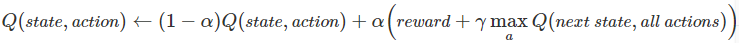

Donde **α** (*alpha*) corresponde al valor del *learning rate* y **γ** (*gamma*) corresponde al factor de descuento, ambos valores entre 0 y 1.

Esta ecuación quiere decir que, se asigna al *valor Q* del estado y acciones actuales, el valor calculado de; un porcentaje *1-α* del antiguo *valor Q*, luego agregando el valor aprendido. Este último es la combinación de la recompensa por realizar la acción actual en el estado actual, y la recompensa máxima descontada del siguiente estado en el que estemos una vez realizada la acción actual.

En resumen, el **Q-Learning** se resume en:
1. Inicialice la *tabla Q* en ceros.
1. Empiece a explorar acciones para cada estado, seleccione cualquiera de las posibles acciones para el estado actual *S*.
1. Muévase al siguiente estado *S'* dada la accion *A*.
1. Para todas las acciones posibles en el estado *S'*, seleccione la que tenga el *valor Q* más alto.
1. Actualice los valores de la *tabla Q* usando la ecuación.
1. Establesca el siguiente estado como el estado actual.
1. Si se alcanza el estado objetivo, finalice y si no, repita el proceso.

#### Explotación de valores aprendidos

Después de mucha exploración aleatoria de acciones, los *valores Q* tienden a converger en valores que le sirven al agente como una función de valor de acción que puede explotar para elegir la acción más óptima de un estado en particular.

En este caso existe una compensación entre la exploración (búsqueda aleatoria) y explotación (elegir acciones basado en *valores Q* ya aprendidos), y se busca evitar que la acción tome siempre la misma ruta y se sobreajuste, por lo que se introduce un nuevo parámetro, *ϵ*. Un valor epsilon bajo da como resultados episodios con más penalizaciones, esto debido a que nos concentramos en explorar tomando decisiones al azar.

#### Implementación del *Q-Learning* en Python

In [15]:
# se importa numpy y se crea la tabla Q con ceros
import numpy as np
qTable = np.zeros( [env.observation_space.n, env.action_space.n] )

In [17]:

# se importan y definen las principales variables para el entrenamiento

import random
from IPython.display import clear_output

# variables hyperparámetros
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# variables para visualización de métricas

all_epochs = []
all_penalties = []

In [20]:
# se entrena
%%time

for i in range(1, 100001):
  state = env.reset()  # selecciona un estado aleatorio

  epochs, penalties, reward = 0, 0, 0
  done = False

  while not done:  # mientras no haya un episodio completo
    if random.uniform(0,1) < epsilon:  # si se cumple el epsilon
      action = env.action_space.sample()  # se explora el espacio
    else:
      action = np.argmax(qTable[state])  # se explotan los valores aprendidos
    
    # se desplaza al estado en la accion tomada
    nextState, reward, done, info = env.step(action)

    # toma el valor anterior
    oldValue = qTable[state, action]

    # toma el siguiente maximo
    nextMax = np.max(qTable[nextState])

    # calcula el nuevo valor
    newValue = (1 - alpha) * oldValue + alpha * (reward + gamma * nextMax)
    
    # setea el nuevo valor
    qTable[state, action] = newValue

    # si se penaliza aumenta el contador
    if reward == -10:
      penalties += 1
    
    # se asigna el nuevo estado
    state = nextState
  
  if i % 100 == 0:
    clear_output(wait=True)
    print(f"Episode:  {i}")
  
print("Entrenamiento terminado")

Episode:  100000
Entrenamiento terminado
CPU times: user 1min 8s, sys: 25 s, total: 1min 33s
Wall time: 1min 11s


In [21]:
# ahora podemos observar el valor en la qTable

qTable[328]

array([ -2.39655291,  -2.27325184,  -2.40260767,  -2.35824346,
       -10.2140601 , -10.41820876])

#### Evaluación con Python

In [23]:
# aquí se realizará la evaluación

# variables para evaluar
total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
  # selecciona un estado al azar
  state = env.reset()

  # inicia los epochs, penalidades, recompensa y done
  epochs, penalties, reward = 0, 0, 0
  done = False

  # verifica mientra no se haya completado un episodio
  while not done:
    # selecciona la acción
    action = np.argmax(qTable[state])

    # se mueve al estado al que lleva la accion elegida
    state, reward, done, info = env.step(action)

    # si la recompensa es negativa
    if reward == -10:
      penalties += 1

    epochs += 1

  total_penalties += penalties
  total_epochs += epochs

print(f"Resultados después de {episodes} episodios:")
print(f"Pasos de tiempo promedio por episodio: {total_epochs / episodes}")
print(f"Penalizaciones promedio por episodio: {total_penalties / episodes}")

Resultados después de 100 episodios:
Pasos de tiempo promedio por episodio: 13.41
Penalizaciones promedio por episodio: 0.0


#### Conclusión de este ejemplo

Como se observa en la evaluación, el desempeño del agente es significativamente bueno, dado que no incurrió en penalizaciones lo que significa que ejecutó las acciones correctas en la recogida y devolución de 100 pasajeros diferentes.

# Parte 2: Adversarial search


Luego de estudiar el siguiente recurso: https://www.youtube.com/watch?v=_3djr6ZXLzQ  (del minuto 04:00:00 hasta el final), debe presentar lo siguiente:
1. Presente un mapa mental o uno conceptual, en que resume el tema presentado en el video. (**10 puntos**)
1. Dado el game tree que se muestra en la Figura siguiente, responda:
    1. En las cajas punteadas, llene los valores de todos los nodos intenos
usando el algoritmo minimax. (**10 puntos**)
    1. Marque los nodos que no son evaluados cuando se usa alpha-beta pruning (suponiendo el recorrido estándar del árbol de izquierda a derecha). (**10 puntos**)
    1. Explique en una celda de texto el procedimiento seguido para el punto anterior. (**10 puntos**)



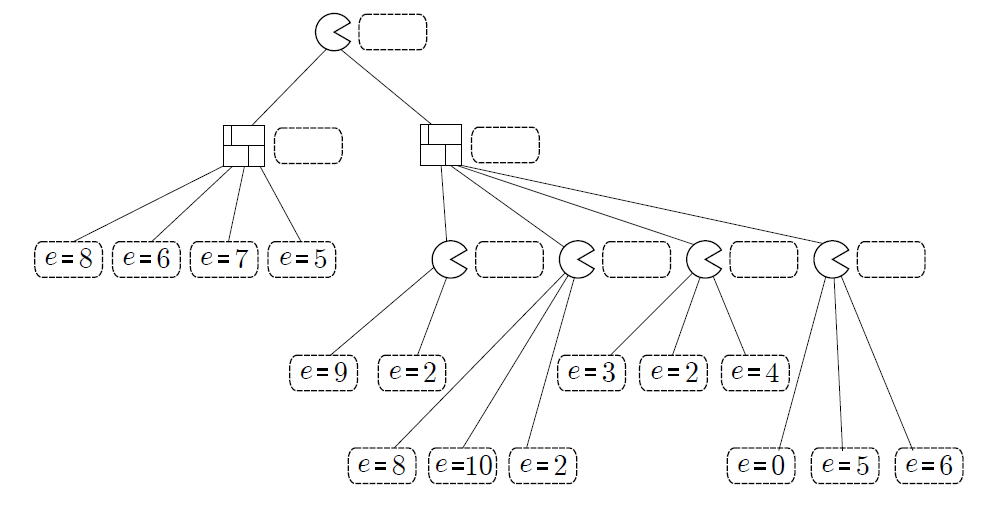

In [ ]:
from IPython.display import Image

Image('grafo.png')

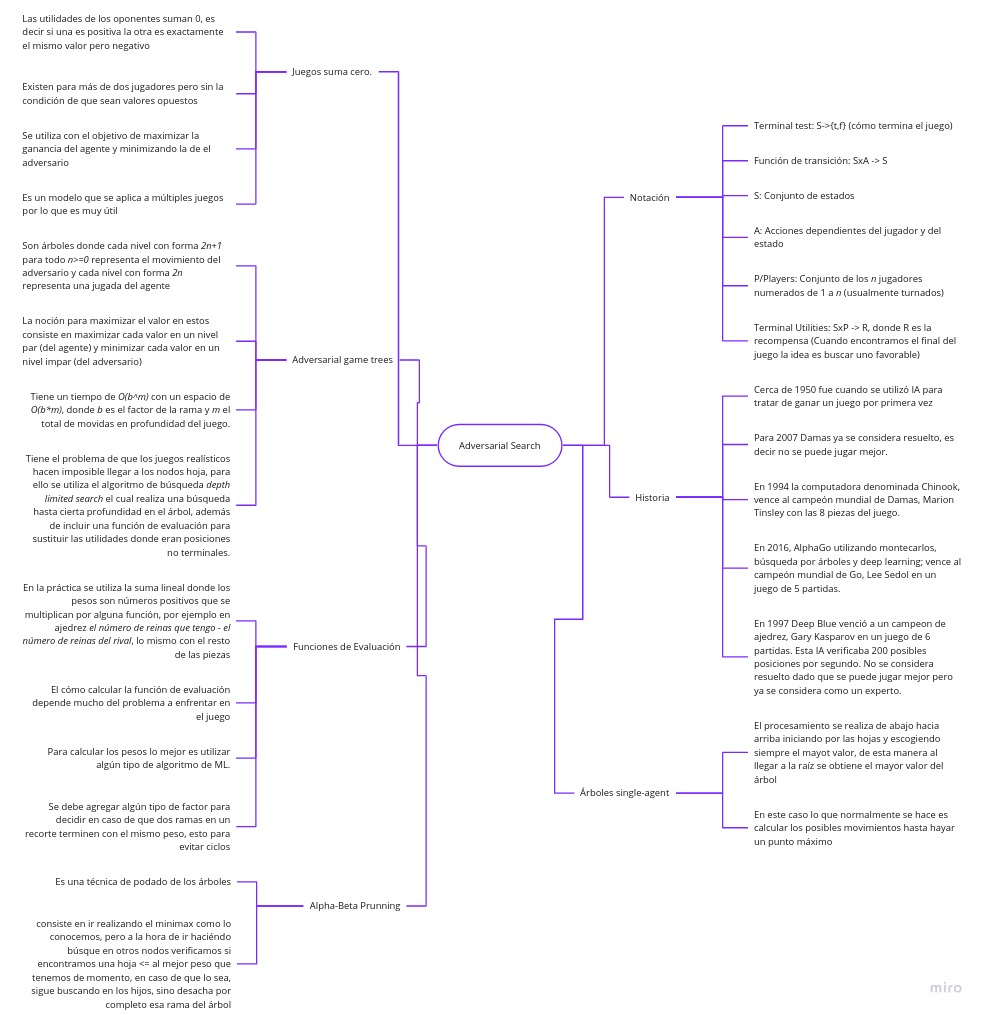

In [ ]:
Image('AdversarialSearchMindMap.jpg')

# Parte 3: Conceptos


Luego de estudiar el siguiente recurso: https://ruder.io/optimizing-gradient-descent/ , prepare un video de no menos de 10 minutos y no más de 20 minutos, en que explica lo más claraente posible los siguientes conceptos: (**30 puntos**)
1. Momentum
1. Nesterov accelerated gradient
1. RMSprop
1. Adam

**Nota:** Puede usar recursos adicionales en caso de que los requiera para comprender mejor algún concepto antes de explicarlo.